#### Find the emission pathways that caused the change in PM2.5 over 2015-2017 in China
- Per gridcell (emulator).  
- Remove the inputs that don't predict the correct change.  

##### Example for January
1. Load observations for 1 station.  
2. Find the change in PM2.5 concentrations for this location over (January) 2015-2017.  
3. Load nearest emulator to this station.  
4. See which inputs the emulator for this location needs to match this change in PM2.5 concentrations.

##### Eventually, swap out the January emulators for the whole year emulators

In [1]:
import glob
import tabula
import joblib
from itertools import islice
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd

In [150]:
### bottom up emissions 2015-2017 - Zheng et al., 2018 ACP
df = tabula.read_pdf('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/zheng2018.pdf', pages=7)
df.drop(columns=['Unnamed: 2', 'Unnamed: 4', 'Unnamed: 9', 'c'], inplace=True)
df.columns = ['sector', 'so2', 'nox', 'nmvoc', 'nh3', 'co', 'tsp', 'pm10', 'pm25', 'bc', 'oc', 'co2']

df_2010 = df.iloc[0:7].copy()
df_2011 = df.iloc[7:14].copy()
df_2012 = df.iloc[14:21].copy()
df_2013 = df.iloc[21:28].copy()
df_2014 = df.iloc[28:35].copy()
df_2015 = df.iloc[35:42].copy()
df_2016 = df.iloc[42:49].copy()
df_2017 = df.iloc[49:56].copy()

df_2010.set_index('sector', inplace=True)
df_2011.set_index('sector', inplace=True)
df_2012.set_index('sector', inplace=True)
df_2013.set_index('sector', inplace=True)
df_2014.set_index('sector', inplace=True)
df_2015.set_index('sector', inplace=True)
df_2016.set_index('sector', inplace=True)
df_2017.set_index('sector', inplace=True)

df_2010 = df_2010.astype('float32').copy()
df_2011 = df_2011.astype('float32').copy()
df_2012 = df_2012.astype('float32').copy()
df_2013 = df_2013.astype('float32').copy()
df_2014 = df_2014.astype('float32').copy()
df_2015 = df_2015.astype('float32').copy()
df_2016 = df_2016.astype('float32').copy()
df_2017 = df_2017.astype('float32').copy()

df_diff = ((100 * df_2017 / df_2015) - 100).copy()
df_diff.drop(['2015', '2017'], inplace=True)
df_diff

,so2,nox,nmvoc,nh3,co,tsp,pm10,pm25,bc,oc,co2
sector,,,,,,,,,,,
Agriculture,NaN,NaN,NaN,-1.030922,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Industry,-38.775513,-5.154640,3.191490,-25.000000,-12.455521,-29.299362,-22.388054,-20.454544,-25.000000,-25.0,-5.302750
Power,-53.846153,-17.647064,0.000000,NaN,6.666672,0.000000,0.000000,0.000000,NaN,NaN,9.054749
Residential,-17.241379,-11.111107,-14.285713,-25.000000,-10.937500,-15.909096,-17.073166,-16.666664,-14.285706,-15.0,3.837296
Solvent use,NaN,NaN,9.473686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Transportation,0.000000,-3.750000,-11.111107,NaN,-12.802765,20.000008,20.000008,0.000000,0.000000,0.0,5.469841


In [10]:
def obs_ds_to_df(filepath):
    ds = xr.open_dataset(filepath)
    df = ds.to_dataframe()
    df['station_id'] = ds.station_id
    df['station_lat'] = ds.station_lat
    df['station_lon'] = ds.station_lon
    df['province'] = ds.province
    df['prefecture'] = ds.city_en
    ds.close()
    df.set_index('times', inplace=True)
    return df

def obs_change_over_2015_2017(df, month, variable):
    df_2015_2017 = df.loc['2015':'2017'].copy()
    
    # for january only
    df_2015_2017_month = df_2015_2017.loc[df_2015_2017.index.month == month].copy()
    df_2015_2017_month_mean = df_2015_2017_month.groupby(df_2015_2017_month.index.year).mean()
    
    change_per = 100 * ((df_2015_2017_month_mean[variable].values[-1] / df_2015_2017_month_mean[variable].values[0]) - 1)
    change_abs = df_2015_2017_month_mean[variable].values[-1] - df_2015_2017_month_mean[variable].values[0]
    return change_per, change_abs

def load_nearest_emulator(df, variable):
    lat = round(df.station_lat.unique()[0] * 4) / 4
    lon = round(df.station_lon.unique()[0] * 4) / 4
    emulator = joblib.load(f'/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/{variable}/emulator_{variable}_{lat}_{lon}.joblib')
    return emulator

In [11]:
month = 1

obs_files = glob.glob('/nfs/a68/earlacoa/china_measurements/*.nc')

obs_change_abs = {}
obs_change_per = {}
emulators = {}
baselines = {}
targets = {}

for obs_file in obs_files:
    station_id = obs_file[37:-3]
    
    df = obs_ds_to_df(obs_file)
    try:
        change_per, change_abs = obs_change_over_2015_2017(df, month, 'PM2.5')

        obs_change_abs.update({station_id: change_abs})
        obs_change_per.update({station_id: change_per})
        
        emulator = load_nearest_emulator(df, 'PM2_5_DRY')
        emulators.update({station_id: emulator})

        baseline = emulator.predict(np.array([[1.0, 1.0, 1.0, 1.0, 1.0]]))
        baselines.update({station_id: baseline})

        target_abs = baseline + change_abs
        target_per = baseline * (1 + (change_per / 100))
        target = np.mean([target_abs, target_per])
        targets.update({station_id: target})
    except:
        IndexError

/nfs/b0122/Users/earlacoa/miniconda3/envs/python3/lib/python3.8/site-packages/sklearn/base.py:313: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/nfs/b0122/Users/earlacoa/miniconda3/envs/python3/lib/python3.8/site-packages/sklearn/base.py:313: UserWarning: Trying to unpickle estimator PowerTransformer from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/nfs/b0122/Users/earlacoa/miniconda3/envs/python3/lib/python3.8/site-packages/sklearn/base.py:313: UserWarning: Trying to unpickle estimator GaussianProcessRegressor from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/nfs/b0122/Users/earlacoa/miniconda3/envs/python3/lib/python3.8/site-packages/sklearn

In [402]:
for key in [key for key in targets.keys()]:
    if np.isnan(targets[key]):
        del targets[key]

In [403]:
target_diffs = {}
for key in [key for key in targets.keys()]:
    target_diffs.update({key: targets[key] - baselines[key]})

In [404]:
for key in list(set([key for key in emulators.keys()]) - set([key for key in targets.keys()])):
    del emulators[key]

In [405]:
joblib.dump(targets, '/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/find_emissions_that_match_pm25_decline/2015-2017/targets.joblib')
joblib.dump(baselines, '/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/find_emissions_that_match_pm25_decline/2015-2017/baselines.joblib')
joblib.dump(target_diffs, '/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/find_emissions_that_match_pm25_decline/2015-2017/target_diffs.joblib')
joblib.dump(emulators, '/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/find_emissions_that_match_pm25_decline/2015-2017/emulators.joblib')

['/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/find_emissions_that_match_pm25_decline/2015-2017/emulators.joblib']

In [ ]:
targets = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/find_emissions_that_match_pm25_decline/2015-2017/targets.joblib')
baselines = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/find_emissions_that_match_pm25_decline/2015-2017/baselines.joblib')
target_diffs = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/find_emissions_that_match_pm25_decline/2015-2017/target_diffs.joblib')
emulators = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/find_emissions_that_match_pm25_decline/2015-2017/emulators.joblib')

In [406]:
matrix_stacked = np.array(np.meshgrid(
    np.linspace(0.3, 1.2, 10), # 1.5 and 16 for 0.1, 1.5 and 6 for 0.3, 1.4 and 8 for 0.2
    np.linspace(0.3, 1.2, 10), # removing edges of parameter space 0.0, 0.1, 1.4, 1.5
    np.linspace(0.3, 1.2, 10), # also removing unlikely reductions in emissions of > -40% or +30%
    np.linspace(0.3, 1.2, 10),
    np.linspace(0.3, 1.2, 10)
)).T.reshape(-1, 5)

station_diffs_abs = {}
station_diffs_per = {}

for station_id, emulator in emulators.items():
    target_diffs_abs = {}
    target_diffs_per = {}
    for matrix in matrix_stacked:
        inputs = matrix.reshape(-1, 5)
        filename = f'RES{inputs[0][0]:.1f}_IND{inputs[0][1]:.1f}_TRA{inputs[0][2]:.1f}_AGR{inputs[0][3]:.1f}_ENE{inputs[0][4]:.1f}'
        target_diff_abs = targets[station_id] - emulator.predict(inputs)[0]
        target_diff_per = (100 * (emulator.predict(inputs)[0] / targets[station_id])) - 100
        if abs(target_diff_per) < 1: # +/- 1% of target
            target_diffs_abs.update({filename: target_diff_abs})
            target_diffs_per.update({filename: target_diff_per})
    
    station_diffs_abs.update({station_id: target_diffs_abs})
    station_diffs_per.update({station_id: target_diffs_per})

In [407]:
keys = [list(station_diffs_per[station].keys())for station in station_diffs_per.keys()]
keys_flatten = [item for sublist in keys for item in sublist]
keys_unique = {}
for key in keys_flatten:
    if key not in keys_unique:
        keys_unique.update({key: 1})
    elif key in keys_unique:
        keys_unique.update({key: keys_unique[key] + 1})

In [408]:
joblib.dump(station_diffs_per, '/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/find_emissions_that_match_pm25_decline/2015-2017/station_diffs_per_1percent.joblib')
joblib.dump(station_diffs_abs, '/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/find_emissions_that_match_pm25_decline/2015-2017/station_diffs_abs_1percent.joblib')

['/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/find_emissions_that_match_pm25_decline/2015-2017/station_diffs_abs_1percent.joblib']

___

In [2]:
targets = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/find_emissions_that_match_pm25_decline/2015-2017/targets.joblib')
baselines = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/find_emissions_that_match_pm25_decline/2015-2017/baselines.joblib')
target_diffs = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/find_emissions_that_match_pm25_decline/2015-2017/target_diffs.joblib')
station_diffs_per = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/find_emissions_that_match_pm25_decline/2015-2017/station_diffs_per_1percent.joblib')
station_diffs_abs = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/find_emissions_that_match_pm25_decline/2015-2017/station_diffs_abs_1percent.joblib')

In [5]:
regional_provinces = {
    'Beijing': 'North China',
    'Tianjin': 'North China',
    'Hebei': 'North China',
    'Shanxi': 'North China',
    'Nei Mongol': 'North China',
    'Liaoning': 'North East China',
    'Jilin': 'North East China',
    'Heilongjiang': 'North East China',
    'Shanghai': 'East China',
    'Jiangsu': 'East China',
    'Zhejiang': 'East China', 
    'Anhui': 'East China', 
    'Fujian': 'East China', 
    'Jiangxi': 'East China', 
    'Shandong': 'East China',
    'Taiwan': 'East China',
    'Henan': 'South Central China',
    'Hubei': 'South Central China',
    'Hunan': 'South Central China',
    'Guangdong': 'South Central China',
    'Guangxi': 'South Central China',
    'Hainan': 'South Central China',
    'Hong Kong': 'South Central China',
    'Macao': 'South Central China',
    'Chongqing': 'South West China',
    'Sichuan': 'South West China',
    'Guizhou': 'South West China',
    'Yunnan': 'South West China',
    'Xizang': 'South West China',
    'Shaanxi': 'North West China',
    'Gansu': 'North West China', 
    'Qinghai': 'North West China',
    'Ningxia Hui': 'North West China',
    'Xinjiang Uygur': 'North West China'
}

gba_prefectures = ['Dongguan', 'Foshan', 'Guangzhou', 'Huizhou', 'Jiangmen', 'Shenzhen', 'Zhaoqing', 'Zhongshan', 'Zhuhai', 'Hong Kong', 'Macao']

In [410]:
# gdf_prefectures_china = gpd.read_file('/nfs/a68/earlacoa/shapefiles/china/gadm36_CHN_3.shp')
# gdf_prefectures_hongkong = gpd.read_file('/nfs/a68/earlacoa/shapefiles/hongkong/gadm36_HKG_1.shp')
# gdf_prefectures_macao = gpd.read_file('/nfs/a68/earlacoa/shapefiles/macao/gadm36_MAC_2.shp')

# list_prefectures_gba = []
# for gba_prefecture in gba_prefectures:
#     list_prefectures_gba.append(gdf.loc[gdf.NAME_2 == gba_prefecture])


# list_prefectures_gba.append(gdf_prefectures_hongkong)
# list_prefectures_gba.append(gdf_prefectures_macao)
    
# gdf_prefectures_gba = pd.concat(list_prefectures_gba)

In [12]:
obs_lats = {}
obs_lons = {}
obs_provinces = {}
obs_prefectures = {}
obs_regions = {}
obs_gba = {}

for obs_file in obs_files:
    with xr.open_dataset(obs_file) as ds:
        key = ds.station_id
        if '.nc' in key:
            key = key[:-3]
            
        if key in targets:
            obs_lats.update({key: ds.station_lat})
            obs_lons.update({key: ds.station_lon})
            obs_provinces.update({key: ds.province})
            obs_prefectures.update({key: ds.city_en})
            obs_regions.update({key: regional_provinces[ds.province]})           
            if (ds.city_en in gba_prefectures) or (ds.city_en == 'Hong Kong') or (ds.city_en == 'Macao'):
                obs_gba.update({key: True})
            else:
                obs_gba.update({key: False})

In [13]:
regions = ['China', 'GBA', 'North China', 'North East China', 'East China', 'South Central China', 'South West China', 'North West China']
region_stations = {key: [] for key in regions}

for station_id, station_region in obs_regions.items():
    region_stations['China'].append(station_id)
    region_stations[station_region].append(station_id)
    
    if obs_gba[station_id] == True:
        region_stations['GBA'].append(station_id)

In [14]:
regional_targets = {}
regional_baselines = {}
regional_target_diffs = {}
regional_station_diffs_per = {}
regional_station_diffs_abs = {}

for region in regions:
    regional_targets.update({region: dict((key, value) for key, value in targets.items() if key in region_stations[region])})
    regional_baselines.update({region: dict((key, value) for key, value in baselines.items() if key in region_stations[region])})
    regional_target_diffs.update({region: dict((key, value) for key, value in target_diffs.items() if key in region_stations[region])})
    regional_station_diffs_per.update({region: dict((key, value) for key, value in station_diffs_per.items() if key in region_stations[region])})
    regional_station_diffs_abs.update({region: dict((key, value) for key, value in station_diffs_abs.items() if key in region_stations[region])})

In [15]:
regional_keys_unique_sorted = {}
regional_target_diffs_under0p5 = {}

for region in regions:
    keys = [list(regional_station_diffs_per[region][station_id].keys()) for station_id in regional_station_diffs_per[region].keys()]
    keys_flatten = [item for sublist in keys for item in sublist]

    keys_unique = {}
    for key in keys_flatten:
        if key not in keys_unique:
            keys_unique.update({key: 1})
        elif key in keys_unique:
            keys_unique.update({key: keys_unique[key] + 1})


    keys_unique_sorted = {key: value for key, value in sorted(keys_unique.items(), key=lambda item: item[1], reverse=True)}
    regional_keys_unique_sorted.update({region: keys_unique_sorted})
    
    target_diffs_under0p5 = {}
    for key, value in regional_target_diffs[region].items():
        if abs(value) < 0.5:
            target_diffs_under0p5.update({key: value})
            
    
    regional_target_diffs_under0p5.update({region: target_diffs_under0p5})

In [16]:
number_of_stations = {}
number_of_emission_configurations = {}
first_emission_configuration_keys = {}
second_emission_configuration_keys = {}
third_emission_configuration_keys = {}
first_emission_configuration_values = {}
second_emission_configuration_values = {}
third_emission_configuration_values = {}
number_of_stations_with_target_diff_under_0p5 = {}

for region in regional_targets.keys():
    number_of_stations.update({region: len(regional_targets[region].keys())})
    number_of_emission_configurations.update({region: len(regional_keys_unique_sorted[region].keys())})
    top3_emission_configurations = list(islice(regional_keys_unique_sorted[region].items(), 3))
    first_emission_configuration_keys.update({region: top3_emission_configurations[0][0]})
    second_emission_configuration_keys.update({region: top3_emission_configurations[1][0]})
    third_emission_configuration_keys.update({region: top3_emission_configurations[2][0]})
    first_emission_configuration_values.update({region: top3_emission_configurations[0][1]})
    second_emission_configuration_values.update({region: top3_emission_configurations[1][1]})
    third_emission_configuration_values.update({region: top3_emission_configurations[2][1]})
    number_of_stations_with_target_diff_under_0p5.update({region: len(regional_target_diffs_under0p5[region])})

In [17]:
df_regions = pd.concat([
    pd.Series(number_of_stations, name='Stations'),
    pd.Series(number_of_emission_configurations, name='Possible Emission Configurations'),
    pd.Series(first_emission_configuration_keys, name='First Emission Configuration - Key'),
    pd.Series(first_emission_configuration_values, name='First Emission Configuration - Value'),
    pd.Series(second_emission_configuration_keys, name='Second Emission Configuration - Key'),
    pd.Series(second_emission_configuration_values, name='Second Emission Configuration - Value'),
    pd.Series(third_emission_configuration_keys, name='Third Emission Configuration - Key'),
    pd.Series(third_emission_configuration_values, name='Third Emission Configuration - Value'),
    pd.Series(number_of_stations_with_target_diff_under_0p5, name='Stations with trend size under 0.5 ugm-3')
], axis=1)
df_regions

,Stations,Possible Emission Configurations,First Emission Configuration - Key,First Emission Configuration - Value,Second Emission Configuration - Key,Second Emission Configuration - Value,Third Emission Configuration - Key,Third Emission Configuration - Value,Stations with trend size under 0.5 ugm-3
China,1462,100000,RES1.2_IND0.7_TRA0.6_AGR0.5_ENE1.1,65,RES1.2_IND0.7_TRA0.6_AGR0.4_ENE1.1,64,RES1.1_IND1.2_TRA0.3_AGR0.4_ENE1.2,63,28
GBA,58,80185,RES0.9_IND1.2_TRA0.9_AGR0.3_ENE0.9,6,RES1.1_IND1.0_TRA0.6_AGR0.4_ENE1.1,6,RES1.1_IND1.2_TRA0.4_AGR0.3_ENE1.2,6,2
North China,137,65887,RES1.1_IND1.2_TRA0.3_AGR0.4_ENE1.2,13,RES1.1_IND1.2_TRA0.3_AGR1.2_ENE1.2,12,RES1.1_IND1.2_TRA0.3_AGR0.3_ENE1.1,11,2
North East China,157,76679,RES1.0_IND0.9_TRA0.8_AGR1.1_ENE0.4,15,RES1.1_IND0.8_TRA0.4_AGR0.4_ENE0.3,15,RES1.1_IND0.8_TRA0.7_AGR0.5_ENE0.3,15,5
East China,456,99951,RES1.2_IND0.6_TRA0.9_AGR0.6_ENE0.8,27,RES1.2_IND0.7_TRA0.6_AGR0.5_ENE0.9,27,RES1.2_IND0.7_TRA0.6_AGR0.5_ENE1.0,27,6
South Central China,356,94457,RES1.1_IND0.4_TRA0.3_AGR1.1_ENE1.1,30,RES1.1_IND0.4_TRA0.4_AGR1.0_ENE1.2,29,RES0.8_IND0.8_TRA0.9_AGR1.2_ENE0.3,29,6
South West China,202,89583,RES1.1_IND0.3_TRA0.4_AGR0.3_ENE0.3,14,RES0.9_IND0.7_TRA0.6_AGR1.1_ENE0.7,14,RES0.9_IND0.9_TRA0.7_AGR0.3_ENE0.8,14,5
North West China,154,87344,RES0.7_IND0.8_TRA0.6_AGR0.6_ENE0.3,9,RES0.6_IND1.0_TRA1.2_AGR0.6_ENE0.3,9,RES0.7_IND0.6_TRA1.1_AGR0.6_ENE0.6,9,4


In [18]:
df_regions.to_csv('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/find_emissions_that_match_pm25_decline/2015-2017/df_regions_1percent.csv')
joblib.dump(regional_keys_unique_sorted, '/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/find_emissions_that_match_pm25_decline/2015-2017/regional_keys_unique_sorted_1percent.joblib')

['/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/find_emissions_that_match_pm25_decline/2015-2017/regional_keys_unique_sorted_1percent.joblib']

In [19]:
df_regions = pd.read_csv('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/find_emissions_that_match_pm25_decline/2015-2017/df_regions_1percent.csv')
regional_keys_unique_sorted = joblib.load('/nfs/b0122/Users/earlacoa/paper_aia_china/emulator/find_emissions_that_match_pm25_decline/2015-2017/regional_keys_unique_sorted_1percent.joblib')

In [20]:
import re
import itertools

region = 'China'
factors_res = {}
factors_ind = {}
factors_tra = {}
factors_agr = {}
factors_ene = {}

for index, items in enumerate(list(itertools.islice(regional_keys_unique_sorted[region].items(), 100))):
    factor_res, factor_ind, factor_tra, factor_agr, factor_ene = [float(item) for item in re.findall('\d+\.\d+',  items[0])]
    factors_res.update({index: factor_res})
    factors_ind.update({index: factor_ind})
    factors_tra.update({index: factor_tra})
    factors_agr.update({index: factor_agr})
    factors_ene.update({index: factor_ene})

In [24]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'axes.grid': False,
    'savefig.dpi': 700,
    'font.size': 12,
    'text.usetex': True,
    'figure.figsize': [5, 5],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

In [22]:
def make_plot(index, keys, values, sector):
    ax = fig.add_subplot(gs[index])
    ax.set_facecolor('whitesmoke')
    plt.xlim([0, 100])
    plt.ylim([0.3, 1.2])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Rank', fontsize=14)
    plt.ylabel('Emission factor', fontsize=14)
    plt.title(sector)
    plt.scatter(keys, values)
    plt.annotate(r'\textbf{' + chr(97 + index) + '}', xy=(0,1.05), xycoords='axes fraction', fontsize=14, weight='bold')

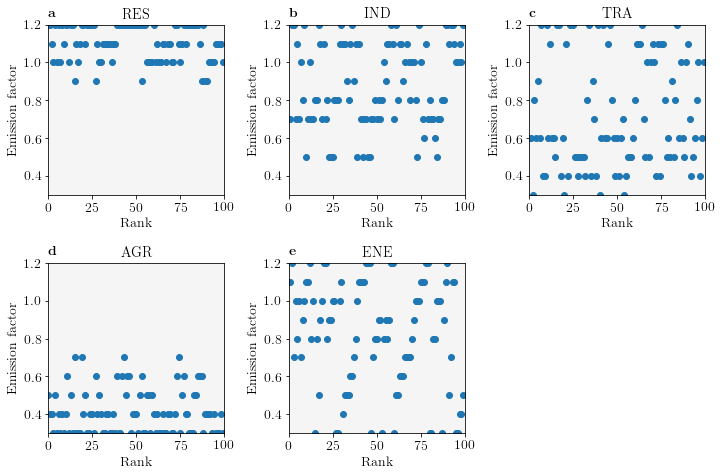

In [25]:
fig = plt.figure(1, figsize=(12, 8))
gs = gridspec.GridSpec(2, 3)

make_plot(0, factors_res.keys(), factors_res.values(), 'RES')
make_plot(1, factors_ind.keys(), factors_ind.values(), 'IND')
make_plot(2, factors_tra.keys(), factors_tra.values(), 'TRA')
make_plot(3, factors_agr.keys(), factors_agr.values(), 'AGR')
make_plot(4, factors_ene.keys(), factors_ene.values(), 'ENE')

gs.tight_layout(fig, rect=[0, 0, 0.85, 0.85])
#plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator/emission_factors_vs_rank.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator/emission_factors_vs_rank.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

In [240]:
def make_boxplot(index, values, sector, bottomup):
    ax = fig.add_subplot(gs[index])
    ax.set_facecolor('whitesmoke')
    plt.ylim([0.2, 1.3])
    plt.yticks(fontsize=14)
    ax.axes.get_xaxis().set_visible(False)
    if index == 0:
        plt.ylabel('Emission factor', fontsize=14)
    else:
        ax.axes.get_yaxis().set_visible(False)
        
    plt.title(sector)
    color1 = '#c7eae5'
    color2 = '#01665e'
    plt.boxplot(
        values, 
        patch_artist=True,
        boxprops={'facecolor': color1, 'color': color2, 'linewidth': 1.5},
        capprops={'color': color2, 'linewidth': 1.5},
        whiskerprops={'color': color2, 'linewidth': 1.5},
        flierprops={'color': color2, 'markeredgecolor': color2, 'linewidth': 1.5},
        medianprops={'color': color2, 'linewidth': 1.5},
        showmeans=True,
        meanprops={'markeredgecolor': color2, 'color': color2},
        showfliers=False,
        whis=(5, 95),
        zorder=1
    )
    plt.scatter(1, bottomup, color='#8c510a', zorder=2, marker='*')
    plt.annotate(r'\textbf{' + chr(97 + index) + '}', xy=(0, 1.05), xycoords='axes fraction', fontsize=14, weight='bold')

In [263]:
zhang2018_bottomup20152017_allspecies_res = 1 + (df_diff.loc['Residential'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152017_allspecies_ind = 1 + (df_diff.loc['Industry'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152017_allspecies_tra = 1 + (df_diff.loc['Transportation'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152017_allspecies_agr = 1 + (df_diff.loc['Agriculture'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)
zhang2018_bottomup20152017_allspecies_ene = 1 + (df_diff.loc['Power'][['so2', 'nox', 'nmvoc', 'nh3', 'co', 'pm25', 'bc', 'oc', 'pm10']].mean() / 100)

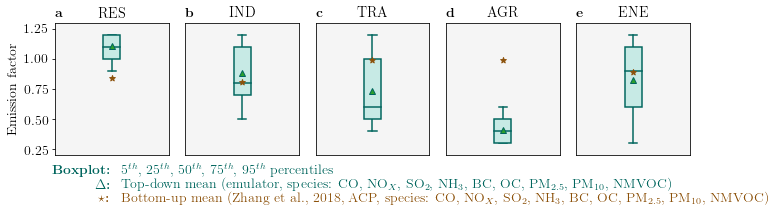

In [265]:
fig = plt.figure(1, figsize=(15, 3))
gs = gridspec.GridSpec(1, 5)

make_boxplot(0, factors_res.values(), 'RES', zhang2018_bottomup20152017_allspecies_res)
make_boxplot(1, factors_ind.values(), 'IND', zhang2018_bottomup20152017_allspecies_ind)
make_boxplot(2, factors_tra.values(), 'TRA', zhang2018_bottomup20152017_allspecies_tra)
make_boxplot(3, factors_agr.values(), 'AGR', zhang2018_bottomup20152017_allspecies_agr)
make_boxplot(4, factors_ene.values(), 'ENE', zhang2018_bottomup20152017_allspecies_ene)

gs.tight_layout(fig, rect=[0, 0, 0.65, 0.85])

plt.annotate(r'\textbf{Boxplot: }', xy=(-4.6, -0.15), xycoords='axes fraction', fontsize=14, color='#01665e')
plt.annotate('5$^{th}$, 25$^{th}$, 50$^{th}$, 75$^{th}$, 95$^{th}$ percentiles', xy=(-4.0, -0.15), xycoords='axes fraction', fontsize=14, color='#01665e')
plt.annotate(r'\textbf{$\Delta$: }', xy=(-4.222, -0.25), xycoords='axes fraction', fontsize=14, color='#01665e')
plt.annotate('Top-down mean (emulator, species: CO, NO$_X$, SO$_2$, NH$_3$, BC, OC, PM$_{2.5}$, PM$_{10}$, NMVOC)', xy=(-4.0, -0.25), xycoords='axes fraction', fontsize=14, color='#01665e')
plt.annotate(r'\textbf{$\star$: }', xy=(-4.21, -0.35), xycoords='axes fraction', fontsize=14, color='#8c510a')
plt.annotate('Bottom-up mean (Zhang et al., 2018, ACP, species: CO, NO$_X$, SO$_2$, NH$_3$, BC, OC, PM$_{2.5}$, PM$_{10}$, NMVOC)', xy=(-4.0, -0.35), xycoords='axes fraction', fontsize=14, color='#8c510a')

plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator/emission_factors_boxplot_top100_1percent.png', dpi=700, alpha=True, bbox_inches='tight')
#plt.savefig('/nfs/b0122/Users/earlacoa/png/paper_aia_emulator/emission_factors_boxplot_top100_1percent.eps', format='eps', dpi=700, alpha=True, bbox_inches='tight')
plt.show()

In [274]:
print(round(zhang2018_bottomup20152017_allspecies_res, 2))
print(round(zhang2018_bottomup20152017_allspecies_ind, 2))
print(round(zhang2018_bottomup20152017_allspecies_tra, 2))
print(round(zhang2018_bottomup20152017_allspecies_agr, 2))
print(round(zhang2018_bottomup20152017_allspecies_ene, 2))

0.84
0.81
0.99
0.99
0.89


0.82

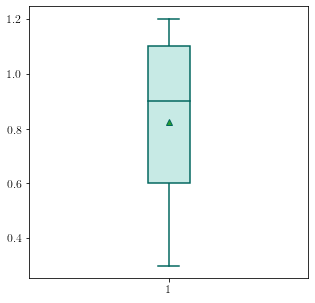

In [284]:
color1 = '#c7eae5'
color2 = '#01665e'
bp = plt.boxplot(
    factors_ene.values(), 
    patch_artist=True,
    boxprops={'facecolor': color1, 'color': color2, 'linewidth': 1.5},
    capprops={'color': color2, 'linewidth': 1.5},
    whiskerprops={'color': color2, 'linewidth': 1.5},
    flierprops={'color': color2, 'markeredgecolor': color2, 'linewidth': 1.5},
    medianprops={'color': color2, 'linewidth': 1.5},
    showmeans=True,
    meanprops={'markeredgecolor': color2, 'color': color2},
    showfliers=False,
    whis=(5, 95),
    zorder=1
)
round(bp['means'][0].get_ydata()[0], 2)